In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import tensorflow as tf
import tensorflow.keras as keras
np.set_printoptions(precision = 4)

In [4]:
path_clean_power = "./data/clean_competitor_market_prices_power.csv"
path_master_market = "./data/master_market.csv"

In [5]:
dtypes = {"date_valid_from": str, "date_valid_to": str, "consumption_range_kwh": np.int32, "price_year_eur": np.float64, "post_code": str}
usecols = [name for name, _ in dtypes.items()]

In [6]:
household = pd.read_csv(path_clean_power, usecols=usecols, dtype = dtypes)

In [7]:
market = pd.read_csv(path_master_market, header = [0], parse_dates=["date"]).drop("Unnamed: 0", axis=1)
market.set_index("date", inplace = True)

In [8]:
market.interpolate(method = "time", axis = 0, inplace = True)

In [9]:
household["date_valid_to"].replace({"9999-12-31": "2022-10-15"}, inplace=True)
household["price_kwh"] = household["price_year_eur"]/household["consumption_range_kwh"]

In [10]:
household["date_valid_from"] = pd.to_datetime(household["date_valid_from"])
household["date_valid_to"] = pd.to_datetime(household["date_valid_to"])

In [11]:
postCodes = household.post_code.unique()
consRanges = household.consumption_range_kwh.unique()

In [12]:
def queryRangePostCode(df_power, consumption_range_kwh = 2000, post_code = "81737") -> pd.DataFrame:
    res = df_power.loc[(df_power.consumption_range_kwh == consumption_range_kwh) & (df_power.post_code == post_code)].copy()
    
    if res.shape[0] > 0:
        #Generating date indexed data
        res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
        res = res.explode("valid_range").copy()

        #Aggregating for mean household prices per day
        res = res.groupby('valid_range').agg({'price_kwh':'mean'})
    return res

In [13]:
df = queryRangePostCode(household, 3500, "81737")
input = df.join(market[["spot", "d01", "d02", "M01", "M02", "M03", "q01", "q02", "y01", "y02"]]/1000)
input.drop(["2022-10-14", "2022-10-15"], inplace=True)

In [14]:
input

,price_kwh,spot,d01,d02,M01,M02,M03,q01,q02,y01,y02
valid_range,,,,,,,,,,,
2021-08-03,0.280969,0.096510,0.09817,0.09389,0.09125,0.09178,0.09851,0.09459,0.09005,0.07610,0.06640
2021-08-04,0.280969,0.098169,0.09451,0.07220,0.09098,0.09206,0.09850,0.09475,0.09053,0.07658,0.06668
2021-08-05,0.280969,0.094510,0.07160,0.06487,0.09139,0.09240,0.09946,0.09528,0.09119,0.07705,0.06705
2021-08-06,0.280969,0.071597,0.06152,0.01190,0.09330,0.09475,0.10155,0.09710,0.09403,0.07903,0.06873
2021-08-07,0.280969,0.061515,0.00563,0.06759,0.09248,0.09393,0.10132,0.09690,0.09434,0.07914,0.06919
...,...,...,...,...,...,...,...,...,...,...,...
2022-10-09,0.820559,0.146725,0.16209,0.25987,0.34489,0.39041,0.54793,0.48409,0.36300,0.42700,0.27000
2022-10-10,0.820559,0.162090,0.25987,0.30167,0.34489,0.39041,0.54793,0.48409,0.36300,0.42700,0.27000
2022-10-11,0.832090,0.259874,0.28254,0.25562,0.34531,0.38275,0.56462,0.50137,0.37100,0.43564,0.27000


<AxesSubplot: xlabel='valid_range'>

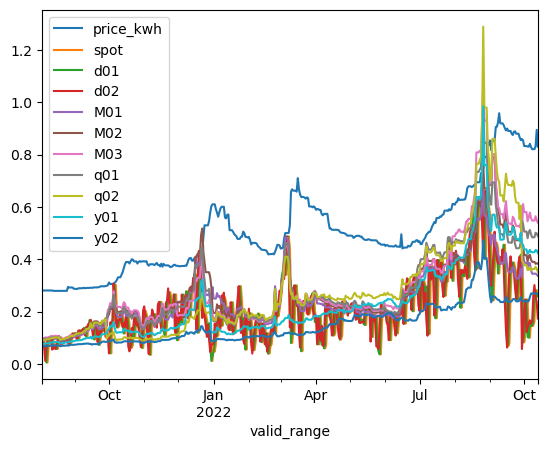

In [15]:
input.plot()

In [73]:
n = len(input)
train_df = input[:int(0.7*n)]
val_df = input[int(0.7*n):int(0.9*n)]
test_df = input[int(0.9*n):]

In [75]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(305, 11)
(88, 11)
(44, 11)


In [29]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [56]:
w1 = WindowGenerator(input_width=5, label_width=1, shift=1, label_columns=["spot"])

In [57]:
w1.label_columns

['spot']

In [37]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [88]:
def plot(self, model=None, plot_col='price_kwh', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [45]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

In [58]:
w1.split_window(example_window)


(<tf.Tensor: shape=(3, 5, 11), dtype=float64, numpy=
 array([[[0.281 , 0.0965, 0.0982, 0.0939, 0.0912, 0.0918, 0.0985, 0.0946,
          0.09  , 0.0761, 0.0664],
         [0.281 , 0.0982, 0.0945, 0.0722, 0.091 , 0.0921, 0.0985, 0.0948,
          0.0905, 0.0766, 0.0667],
         [0.281 , 0.0945, 0.0716, 0.0649, 0.0914, 0.0924, 0.0995, 0.0953,
          0.0912, 0.077 , 0.067 ],
         [0.281 , 0.0716, 0.0615, 0.0119, 0.0933, 0.0948, 0.1016, 0.0971,
          0.094 , 0.079 , 0.0687],
         [0.281 , 0.0615, 0.0056, 0.0676, 0.0925, 0.0939, 0.1013, 0.0969,
          0.0943, 0.0791, 0.0692]],
 
        [[0.3821, 0.1904, 0.1669, 0.1528, 0.1502, 0.1645, 0.1667, 0.1544,
          0.0943, 0.1134, 0.0847],
         [0.3862, 0.1669, 0.1569, 0.139 , 0.1578, 0.1722, 0.1728, 0.1608,
          0.0955, 0.1155, 0.0852],
         [0.3788, 0.1569, 0.1693, 0.228 , 0.163 , 0.1803, 0.1836, 0.1694,
          0.0964, 0.1188, 0.0874],
         [0.3788, 0.1693, 0.228 , 0.2375, 0.163 , 0.1803, 0.1836, 0.1694

In [33]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [35]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [59]:
w1.make_dataset(train_df)

<MapDataset element_spec=(TensorSpec(shape=(None, 5, 11), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>

In [62]:
w1.val.element_spec

(TensorSpec(shape=(None, 5, 11), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [68]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 5, 11)
Labels shape (batch, time, features): (32, 1, 1)


# Single Step Model

In [69]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['price_kwh'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['price_kwh']

In [70]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


In [91]:
baseline = Baseline(label_index=0)

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

3/3 [==============================] - 0s 3ms/step - loss: 3.1874e-04 - mean_absolute_error: 0.0101


ValueError: `sampling_rate` must be lower than the length of the data. Received: sampling_rate=1, for data of length 0

In [79]:
val_performance

{'Baseline': [0.0003187427937518805, 0.01011411752551794]}

In [84]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['price_kwh'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['price_kwh']

In [85]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 11)
Output shape: (32, 24, 1)


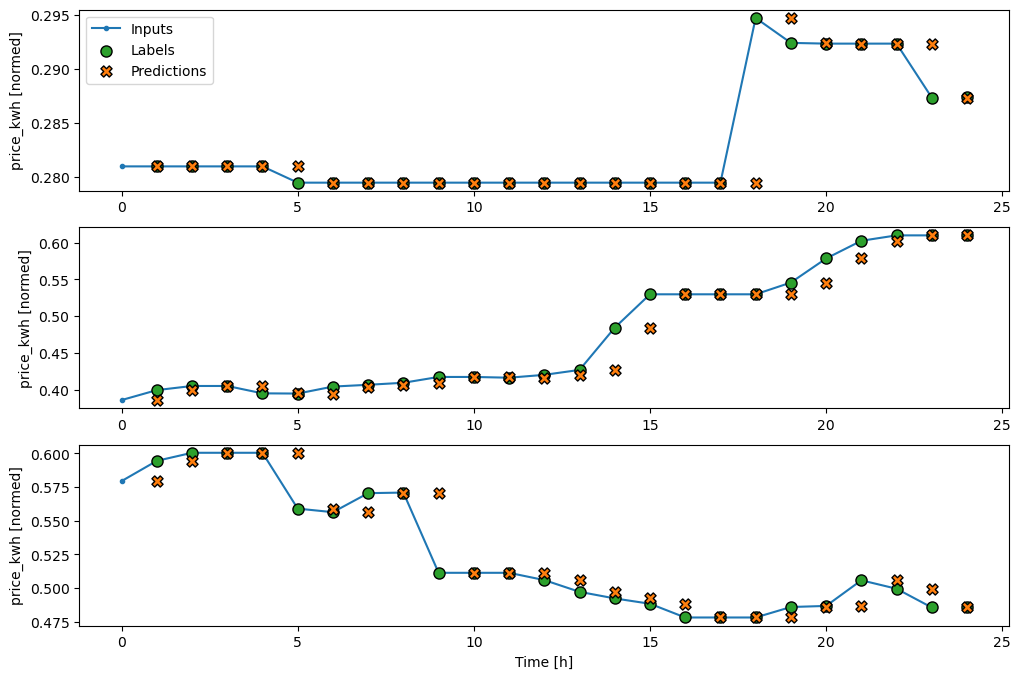

In [90]:
wide_window.plot(baseline)